## ROC Functions 

In [400]:
import pandas as pd
import numpy as np
# import os

from ipywidgets import IntProgress
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import CubicSpline


#Data Type for ROC graphs (Data name, False Positives, True Positives, False Negatives, True Negatives)
def ROC_DATA(label, FP='-', TP='-', FN='-', TN='-'):
    obj = {'Label':label }
    if(not(FP is '-')):
        obj['FP'] = FP
    if(not(FN is '-')):
        obj['FN'] = FN
    if(not(TP is '-')):
        obj['TP'] = TP
    if(not(TN is '-')):
        obj['TN'] = TN
    return obj



#makes ROC_DATA for a all columns in a df
def getRate(df, col, label='Default'):
    FP, TP = [], []
    FN, TN = [], []
    for i in range(0, 100):
        threshold=i/100.
        FP.append(len(df[(df[col]<threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
        TP.append(len(df[(df[col]<threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
        FN.append(len(df[(df[col]>threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
        TN.append(len(df[(df[col]>threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
    return ROC_DATA(label, TP=TP, FP=FP, TN=TN, FN=FN)



#Plot an array of ROC_DATA
def plotRocs(rocObjArray):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(1,1,1)
    for rocData in rocObjArray:
        d = skimROC_Data(rocData)
        label = d['Label']
        FP, TP = d['FP'], d['TP']
        ax.plot(FP,TP,'-' ,label = label,zorder = -32, alpha=.5)
    handles, labels = ax.get_legend_handles_labels()
    display = (0,71)
    ax.set_xlabel('FP Rate')
    ax.set_xlim(0,1)
    ax.set_ylabel('TP Rate')
    ax.set_ylim(0,1)
    ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
    ax.set_title('ROC Curve Compliation')
    ax.legend()
    
    
#Limits columns in a DF to a particular value
def limitVal(df, ignore = ['Success'], N = 1.):
    for c in df.columns.drop(ignore):
        df[c].where(df[c] <= N, N) 
    return df

#Takes the average of all columns in a df
def avgVal(df, ignore = ['Success'], colName = "AvgPred"):
    df[colName] = df.drop(columns=ignore).mean(axis=1)
    return df

def skimROC_Data(d):
    x, y = [], []
    for i in range(0, len(d['FP'])):
        curX, curY = d['FP'][i], d['TP'][i]
        if(len(x) == 0):
            x.append(curX)
            y.append(curY)
        elif(not curX == x[-1:][0]):
            x.append(curX)
            y.append(curY)
    return {"Label":d['Label'], 'FP':x, 'TP':y}

def rocPercent(roc):
    data = skimROC_Data(roc)
    f = InterpolatedUnivariateSpline(data['FP'], data['TP'], k=1)
    plt.plot(f)
    return data['Label'] + "'s Integral is: "+str(f.integral(0.,1.))

def rocPercents(rocData):
    for roc in rocData:
        pct = rocPercent(roc)
        print(pct)


TypeError: float() argument must be a string or a number, not 'InterpolatedUnivariateSpline'

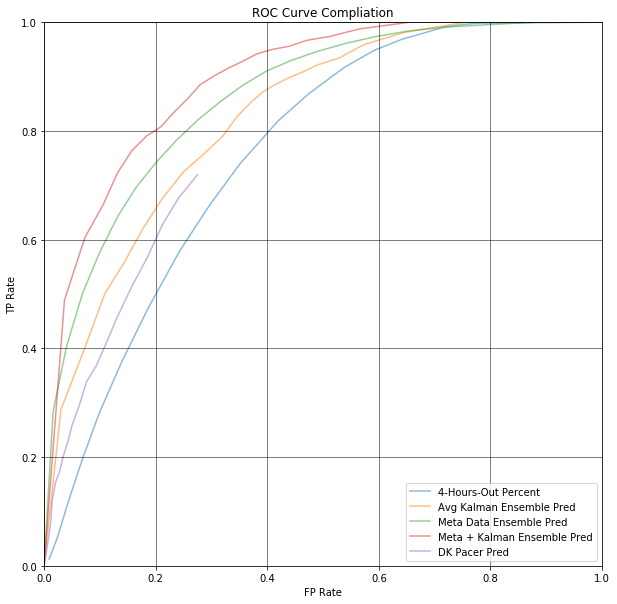

In [401]:
rocData = [fourHourRates, kalmanRate, metaRate, combinedRate, pacerRate]
plotRocs(rocData)
rocPercents(rocData)

0.7585487520545
0.5912308016464582
0.735385748886429
0.5617196324290297
0.1231550333174189


In [337]:
rocPercents(rocData)
# sortROC(copy)

0.7585487520545


ValueError: x must be strictly increasing

## Forest Functions

In [252]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

#Samples DF for an approximate numnber of rows  (Needed for balanceDF)
def cutDF(df, intendedNumber):
    df = df.sample(frac=intendedNumber/len(df), replace=True)
    return df

#Returns DF with 50/50 split on specified binary column
def balanceDF(df, colName, numberOfEach = 0):
    successDF, failDF = df[df[colName] == 1], df[df[colName] == 0]
    if(numberOfEach == 0):
        maxContestsForBalance = min(len(successDF), len(failDF))
        numberOfEach = int(maxContestsForBalance*.1)
    combinedDF = pd.concat([cutDF(successDF, numberOfEach), cutDF(failDF, numberOfEach)])
    return combinedDF.sample(frac=1)

#Splits a df into two parts, for testing and training
def splitTrainingTesting(df, percentTrain, TYPE='None'):
    df = df.copy(deep=True)
    if(TYPE=="CLF"):
        df['Success'] = df['Success'].astype('int')
    elif(TYPE=='REGR'):
        df['Success'] = df['Success'].astype('float')
    df['is_train'] = np.random.uniform(0, 1, len(df)) <= percentTrain
    trainDF, testDF = df[df['is_train']==True], df[df['is_train']==False]
    df = df.drop(columns=['is_train'], axis=1)
    trainDF = trainDF.drop(['is_train'], axis=1)
    testDF = testDF.drop(['is_train'], axis=1)
    return trainDF, testDF


#Simple wrapper for a making a classifier
def classifierWrapper(trainDF, classifierType, balanced=True):
    trainDF = trainDF.copy(deep=True)
    if(balanced):
        trainDF = balanceDF(trainDF, 'Success')
    clf = makeAndTrainCLF(trainDF, classifierType)
    columns = trainDF.columns.drop('Success')
    return {"clf":clf, "cols":columns}

#Trains a classifier of the provided 
def makeAndTrainCLF(trainDF, classifierType, successCol = 'Success'): ####################
    clf = classifierType()
    clf.fit(trainDF[trainDF.columns.drop(successCol)], trainDF[successCol].astype('int'))
    return clf
#
def EnsembleWithMinAcc(trainDF, classifierType, balanced=True, numCLF = 20, accuracy=0.):
    CLFS = []
    for i in range(0, numCLF):
        currAcc = -1.
        while(currAcc < accuracy):
            clf = classifierWrapper(trainDF, RandomForestClassifier, balanced=balanced)
            currAcc = accuracy_score(clf['clf'].predict(trainDF[clf['cols']]), trainDF['Success'])
        CLFS.append(clf)
    return CLFS

def getEnsPred(testDF, CLFS):
    rDF = testDF[['Success']].copy(deep=True)
    count = 0
    for CLF in CLFS:
        count+=1
        classifier, columns = CLF['clf'], CLF['cols']
        rDF['CLF'+str(count)] = classifier.predict(testDF[columns])
    return rDF

### Data Files for ROC

In [273]:
print("... Importing data")
contests = pd.read_csv('data/WorkedData.csv').set_index('ContestId').drop(columns=['FillGapDollars', 'TrueLoss'])
qrPredsDF = limitVal(pd.read_csv('data/QR_Preds.csv').set_index('ContestId').drop(columns=['is_train']),N=1.)
combinedQRContestsDF = pd.merge(contests, qrPredsDF.drop(columns=['Success']), on='ContestId', how='left').dropna()
brownDF = pd.read_csv('data/browncurve.csv', header=None, names=['FP', 'TP'])
pacerDF = pd.read_csv('data/DK_Pacer_Success.csv').set_index('ContestId')

... Importing data


In [276]:
pacerRate = getRate(pacerDF, 'PacerSuccess', label='DK Pacer Pred')

### Calculating ROC_DATA

In [338]:
print("... Calculating Baseline 4-hours-out Prediction")
fourHourRates = ROC_DATA('4-Hours-Out Percent', FP=brownDF['FP'].values, TP=brownDF['TP'].values)

print("... Calculating Average Kalman Filter Prediction")
avgRate = getRate(avgVal(qrPredsDF), 'AvgPred', label='Avg Kalman Pred')

print("... Kalman Ensemble")
trainDF, testDF = splitTrainingTesting(qrPredsDF, .75, TYPE='CLF')
CLFS = EnsembleWithMinAcc(trainDF, RandomForestClassifier, accuracy = .6)
kalmanRate = getRate(avgVal(getEnsPred(testDF, CLFS), ignore=[]), 'AvgPred', label='Avg Kalman Ensemble Pred')

print("... Meta Data Ensemble")
trainDF, testDF = splitTrainingTesting(contests, .75, TYPE='CLF')
CLFS = EnsembleWithMinAcc(trainDF, RandomForestClassifier, accuracy = .6)
metaRate = getRate(avgVal(getEnsPred(testDF, CLFS), ignore=[]), 'AvgPred', label='Meta Data Ensemble Pred')

print("... Combined Meta + Kalman Ensemble")
trainDF, testDF = splitTrainingTesting(combinedQRContestsDF, .75, TYPE='CLF')
CLFS = EnsembleWithMinAcc(trainDF, RandomForestClassifier, accuracy = .6)
combinedRate = getRate(avgVal(getEnsPred(testDF, CLFS), ignore=[]), 'AvgPred', label='Meta + Kalman Ensemble Pred')

... Calculating Baseline 4-hours-out Prediction
... Calculating Average Kalman Filter Prediction
... Kalman Ensemble
... Meta Data Ensemble
... Combined Meta + Kalman Ensemble


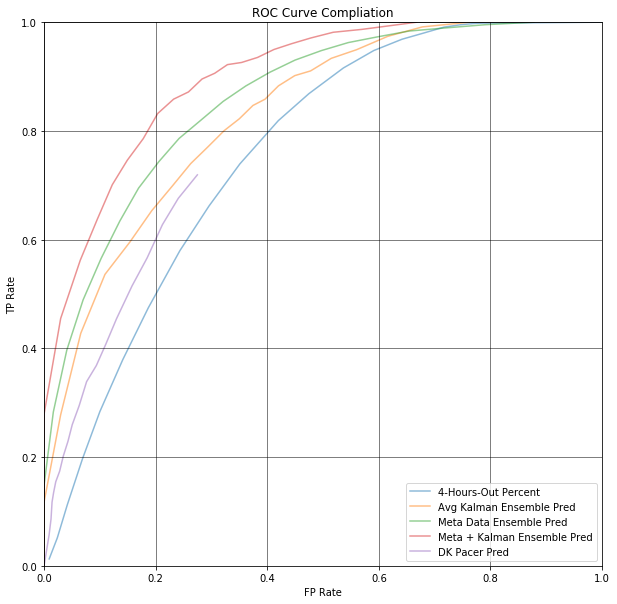

In [320]:
rocData = [fourHourRates, kalmanRate, metaRate, combinedRate, pacerRate]
plotRocs(rocData)

In [156]:
print("... Importing data")
percentSuccessDF = pd.read_csv('data/WorkingData.csv').set_index('ContestId')[['Entries', 'MaxNumberPlayers']]
percentSuccessDF['Success%'] = temp['Entries']/temp['MaxNumberPlayers']
percentSuccessDF = percentSuccessDF[['Success%']]
contests = pd.read_csv('data/WorkedData.csv')
qrPredsDF = limitVal(pd.read_csv('data/QR_Preds.csv').set_index('ContestId').drop(columns=['is_train']),N=1.)
qrPredsRegrDF = pd.merge(qrPredsDF, percentSuccessDF, on='ContestId', how='left')
qrPredsRegrDF['Success'] = qrPredsRegrDF['Success%']
qrPredsRegrDF = qrPredsRegrDF.drop(columns=['Success%'])
brownDF = pd.read_csv('data/browncurve.csv', header=None, names=['FP', 'TP'])

print("... Calculating Average Kalman Filter Prediction")
avgRate = getRate(avgVal(qrPredsDF), 'AvgPred', label='Avg Kalman Pred')

print("... Calculating Average Kalman Filter Prediction")
fourHourRates = ROC_DATA('4-Hours-Out Percent', FP=brownDF['FP'].values, TP=brownDF['TP'].values)

#Random Forest of Kalman Filter Prediction
# print("... Random Forest of Kalman Filter Prediction")
# trainDF, testDF = splitTrainingTesting(qrPredsDF, .75)
# CLFS = makeForestWithMinAcc(trainDF, trainDF['Success'].astype('int'), accuray = .6)
# kalmanEnsRate = getRatesCLF(testDF, CLFS, label="Kalman Ensemble")

... Importing data
... Calculating Average Kalman Filter Prediction
... Calculating Average Kalman Filter Prediction


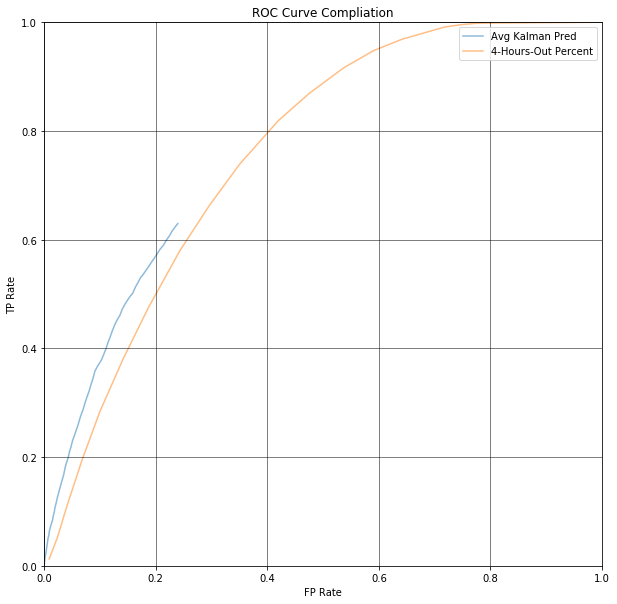

In [34]:
rocObjArray = [avgRate, fourHourRates]
plotRocs(rocObjArray)